## Developed by: Saad Aldin Mohamed
## email: sa3danny@yahoo.com

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 4)

# Ignore useless warnings
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# ------------------------------------- Data preparation -------------------------------------------

In [2]:
activation_data = pd.read_excel('Activation_status_data.xlsx')
activation_data = pd.DataFrame(activation_data)
activation_data.head(3)

,name,activated,N2_BET,N2_Langmiur,last solvent,method
0,ACAJIZ_clean,yes,0.0,0.0,chloroform,exchange
1,ACAJOF_clean,yes,0.0,0.0,chloroform,exchange
2,ACUFEK_clean,yes,NaN,3800.0,dichloromethane,exchange


In [3]:
activation_data['activated'].unique()

array(['yes', nan, 'no', 'dup-remove', 'hypo-remove'], dtype=object)

In [4]:
## Remove duplicate and hypothetical enteries
dup_remove = activation_data[activation_data['activated']=='dup-remove'].index
hypo_remove = activation_data[activation_data['activated']=='hypo-remove'].index
activation_data = activation_data.drop(dup_remove)
activation_data = activation_data.drop(hypo_remove)

print ('Removed duplicate enteries = ', len(dup_remove))
print ('Removed hypothetical enteries = ', len(hypo_remove))
print ('size of the remaining data = ', len(activation_data))

Removed duplicate enteries =  49
Removed hypothetical enteries =  6
size of the remaining data =  280


# ----------------------------------    Elastic Constants   ------------------------------------

In [5]:
elastic = pd.read_csv("Elastic_properties_strain_1.0.csv")
elastic = pd.DataFrame(elastic)

In [6]:
#check  negative values
columns = elastic.columns
for i in columns[1:]:
    negatives_ind = elastic[elastic[i]<0].index
    print (i, negatives_ind.tolist())

Kv []
Kr [14, 37, 65, 97, 101, 102, 112, 121, 154, 157, 160, 182, 185, 211, 245, 249, 270, 288, 290, 298]
Gv [25]
Gr [2, 14, 24, 59, 65, 69, 97, 101, 102, 112, 120, 121, 150, 154, 157, 182, 211, 232, 241, 249, 270, 288, 289, 298]


In [7]:
#Round negative values to zero
columns = elastic.columns
for i in columns[1:]:
    negatives_ind = elastic[elastic[i]<0].index
    elastic.loc[negatives_ind, i] = 0

In [8]:
#check that the negative values were all rounded
columns = elastic.columns
for i in columns[1:]:
    negatives_ind = elastic[elastic[i]<0].index
    print (i, negatives_ind.tolist())

Kv []
Kr []
Gv []
Gr []


In [9]:
# Cacualte young modulus (Reuss and Voigt)
elastic['Ev'] = (9*elastic['Kv']*elastic['Gv'])/(3*elastic['Kv']+elastic['Gv'])
elastic['Er'] = (9*elastic['Kr']*elastic['Gr'])/(3*elastic['Kr']+elastic['Gr'])

# For some of cases; both Kr and Gr are zeros,
# therefore the estimated Er should be zero instead of 'nan'

elastic['Er'] = elastic['Er'].fillna(0);

In [10]:
# Check
Er_0 = elastic[(elastic['Kr'] == 0) &(elastic['Gr'] == 0)]
Er_0.head(3)

,name,Kv,Kr,Gv,Gr,Ev,Er
14,ASIVAB_clean,11.365,0.0,2.413,0.0,6.760538,0.0
65,EPOTAF_clean,1.460,0.0,0.413,0.0,1.132239,0.0
97,IDUDIW_clean,21.206,0.0,17.476,0.0,41.129609,0.0


In [11]:
#Calcualte average properties (Hill)
elastic['K'] = (elastic['Kv']+elastic['Kr'])/2
elastic['G'] = (elastic['Gv']+elastic['Gr'])/2
elastic['E'] = (elastic['Ev']+elastic['Er'])/2

elastic.head(3)

,name,Kv,Kr,Gv,Gr,Ev,Er,K,G,E
0,ACAJIZ_clean,25.416,11.888,18.703,10.893,45.056914,25.033053,18.6520,14.798,35.044984
1,ACAJOF_clean,4.809,4.578,8.241,3.267,15.734900,7.917589,4.6935,5.754,11.826245
2,ACUFEK_clean,13.441,10.554,0.854,0.000,2.508865,0.000000,11.9975,0.427,1.254432


In [12]:
# For most of MOFs, the lower bound correspond to that estimated with the Reuss method
# However, for very few cases; the lower bound was asscociated with Voigt method
# This probably due to instability of the crystal, or in-adequency of the force field or the adopted method.
# Indeed we have to remove these MOFs

ind = elastic[(elastic['Kr']>elastic['Kv'])|
                          (elastic['Gr']>elastic['Gv'])|
                          (elastic['Er']>elastic['Ev'])].index

elastic = elastic.drop(ind)

In [13]:
activation_elastic = pd.merge(elastic, activation_data, on = 'name', how = "inner" )
activation_elastic.head(3)

,name,Kv,Kr,Gv,Gr,Ev,Er,K,G,E,activated,N2_BET,N2_Langmiur,last solvent,method
0,ACAJIZ_clean,25.416,11.888,18.703,10.893,45.056914,25.033053,18.6520,14.798,35.044984,yes,0.0,0.0,chloroform,exchange
1,ACAJOF_clean,4.809,4.578,8.241,3.267,15.734900,7.917589,4.6935,5.754,11.826245,yes,0.0,0.0,chloroform,exchange
2,ACUFEK_clean,13.441,10.554,0.854,0.000,2.508865,0.000000,11.9975,0.427,1.254432,yes,NaN,3800.0,dichloromethane,exchange


In [14]:
activated_elastic = activation_elastic[(activation_elastic['activated'] == 'yes')]
collapsed_elastic = activation_elastic[(activation_elastic['activated'] == 'no')]

print ('Activated MOFs', len(activated_elastic))
print ('collapsed MOFs', len(collapsed_elastic))

Activated MOFs 170
collapsed MOFs 30


In [15]:
from sklearn.neighbors import KernelDensity

def kde_calculations(x1, x2):
    mi = min(min(x1), min(x2))
    mx = max(max(x1), max(x2))
    x_d = np.linspace(0, mx*1.1 ,1000)
    bw = (mx-mi)/15


    # fitting the activated MOFs
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(x1[:, None])
    log_density_1 = kde.score_samples(x_d[:, None])
    # fitting the collapsed MOFs
    kde = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde.fit(x2[:, None])
    log_density_2 = kde.score_samples(x_d[:, None])
    return x_d, log_density_1, log_density_2

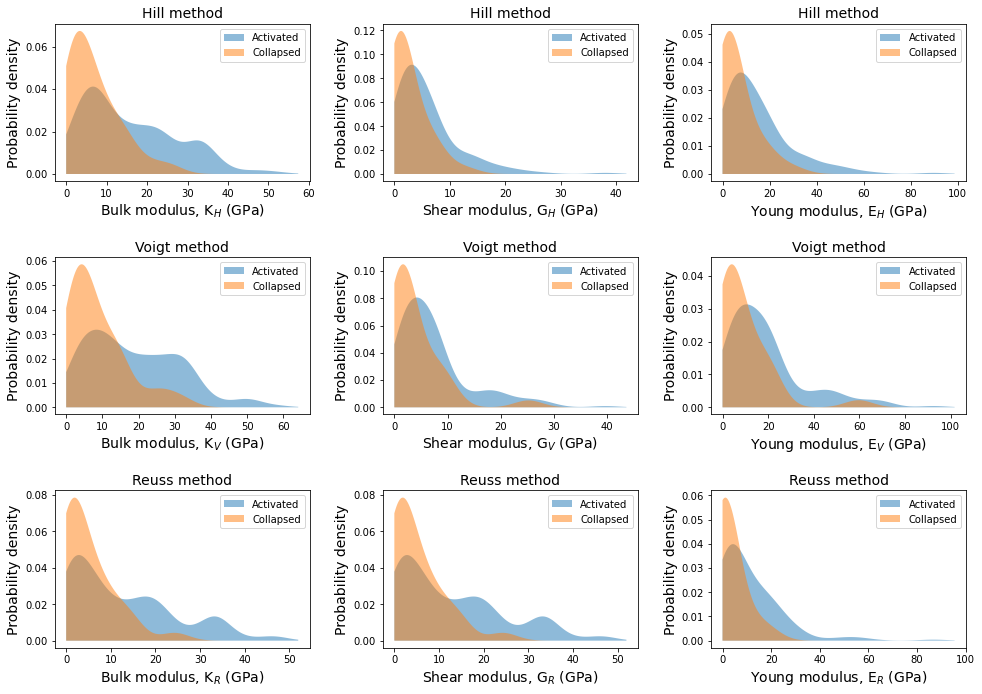

In [16]:
from sklearn.neighbors import KernelDensity
plt.figure(figsize=(14,10))


#---------------------------------------------------------------------#
plt.subplot(331)
x1 = activated_elastic['K']
x2 = collapsed_elastic['K']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Hill method", fontsize = 14)
plt.xlabel("Bulk modulus, K${_H}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(332)
x1 = activated_elastic['G']
x2 = collapsed_elastic['G']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Hill method", fontsize = 14)
plt.xlabel("Shear modulus, G${_H}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(333)
x1 = activated_elastic['E']
x2 = collapsed_elastic['E']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Hill method", fontsize = 14)
plt.xlabel("Young modulus, E${_H}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(334)
x1 = activated_elastic['Kv']
x2 = collapsed_elastic['Kv']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Voigt method", fontsize = 14)
plt.xlabel("Bulk modulus, K${_V}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(335)
x1 = activated_elastic['Gv']
x2 = collapsed_elastic['Gv']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Voigt method", fontsize = 14)
plt.xlabel("Shear modulus, G${_V}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(336)
x1 = activated_elastic['Ev']
x2 = collapsed_elastic['Ev']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Voigt method", fontsize = 14)
plt.xlabel("Young modulus, E${_V}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(337)
x1 = activated_elastic['Kr']
x2 = collapsed_elastic['Kr']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Reuss method", fontsize = 14)
plt.xlabel("Bulk modulus, K${_R}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)


#---------------------------------------------------------------------#
plt.subplot(338)
x1 = activated_elastic['Gr']
x2 = collapsed_elastic['Gr']

kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Reuss method", fontsize = 14)
plt.xlabel("Shear modulus, G${_R}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#---------------------------------------------------------------------#
plt.subplot(339)
x1 = activated_elastic['Er']
x2 = collapsed_elastic['Er']

x_d, log_density_1, log_density_2 = kde_calculations(x1, x2)

plt.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
plt.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')
plt.legend(loc ='upper right')
plt.title("Reuss method", fontsize = 14)
plt.xlabel("Young modulus, E${_R}$ (GPa)", fontsize = 14)
plt.ylabel("Probability density", fontsize = 14)

#------------------------------------------------------------------------------------------------------
plt.tight_layout(pad=2.0)

plt.savefig("Probability density - Elastic.png", dpi=200)


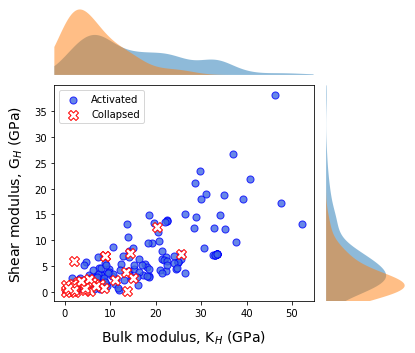

In [17]:
from matplotlib.ticker import NullFormatter
from sklearn.neighbors import KernelDensity

#-----------------------------------------------
xa = activated_elastic['K']
xc = collapsed_elastic['K']

ya = activated_elastic['G']
yc = collapsed_elastic['G']

Xlabel = "Bulk modulus, K${_H}$ (GPa)"
Ylabel = "Shear modulus, G${_H}$ (GPa)"
#------------------------------------------------

#https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html

# definitions for the axes
left, width = 0.15, 0.6
bottom, height = 0.15, 0.6
spacing = 0.02
 
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(6, 5))

ax_scatter = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

# no labels
nullfmt = NullFormatter()   
ax_histx.xaxis.set_major_formatter(nullfmt)
ax_histy.yaxis.set_major_formatter(nullfmt)

#------------------------------  the scatter plot -------------------------------#
ax_scatter.scatter(x=xa, y =ya, c = 'royalblue', edgecolor ='blue', alpha = 0.8,
            s =50,  label = "Activated")
ax_scatter.scatter(x=xc, y =yc, marker= "X", s =100,
            edgecolor ='r', c ='w', label = "Collapsed")
ax_scatter.legend(loc ='upper left')
ax_scatter.set_xlabel(Xlabel, fontsize = 14, labelpad= 10)
ax_scatter.set_ylabel(Ylabel, fontsize = 14, labelpad= 10)

#------------------------------ Upper histogram ---------------------------------#
xlim1, xlim2 = ax_scatter.get_xlim()
x_d = np.linspace(xlim1, xlim2 ,1000)
mi1 = min(min(xa), min(xc))
mx1 = max(max(xa), max(xc))
bw = (mx1-mi1)/15

# fitting activated
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xa[:, None])
log_density_1 = kde.score_samples(x_d[:, None])
# fitting collapsed
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xc[:, None])
log_density_2 = kde.score_samples(x_d[:, None])
ax_histx.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
ax_histx.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')

#----------------------------- Right histogram --------------------------------#

ylim1, ylim2 = ax_scatter.get_ylim()
y_d = np.linspace(ylim1, ylim2 ,1000)
mi2 = min(min(ya), min(yc))
mx2 = max(max(ya), max(yc))
bw = (mx2-mi2)/15

# fitting the activated MOFs
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(ya[:, None])
log_density_1 = kde.score_samples(y_d[:, None])
# fitting the collapsed MOFs
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(yc[:, None])
log_density_2 = kde.score_samples(y_d[:, None])
#----
ax_histy.fill_betweenx(y_d, np.exp(log_density_1), alpha=0.5, label='Activated')
ax_histy.fill_betweenx(y_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')

#--------- axises limits of the histograms should be same as for the scatter plots ---------#

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#------------------ remove the axis and frame of the histograms ----------------------------#
ax_histx.set_yticks([])
ax_histy.set_xticks([])
ax_histx.axis('off')
ax_histy.axis('off')
#--------------------------------------------------------------------------------------------#

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)

plt.savefig("Bulk(K) vs Shear(G)", dpi=200)


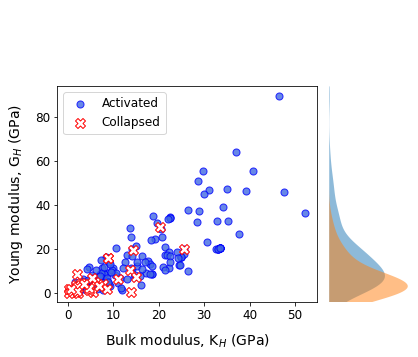

In [18]:
from matplotlib.ticker import NullFormatter
from sklearn.neighbors import KernelDensity

#-----------------------------------------------
xa = activated_elastic['K']
xc = collapsed_elastic['K']

ya = activated_elastic['E']
yc = collapsed_elastic['E']

Xlabel = "Bulk modulus, K${_H}$ (GPa)"
Ylabel = "Young modulus, G${_H}$ (GPa)"
#------------------------------------------------

#https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html

# definitions for the axes
left, width = 0.15, 0.6
bottom, height = 0.15, 0.6
spacing = 0.02
 
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(6, 5))

ax_scatter = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

# no labels
nullfmt = NullFormatter()   
ax_histx.xaxis.set_major_formatter(nullfmt)
ax_histy.yaxis.set_major_formatter(nullfmt)

#------------------------------  the scatter plot -------------------------------#
ax_scatter.scatter(x=xa, y =ya, c = 'royalblue', edgecolor ='blue', alpha = 0.8,
            s =50,  label = "Activated")
ax_scatter.scatter(x=xc, y =yc, marker= "X", s =100,
            edgecolor ='r', c ='w', label = "Collapsed")
ax_scatter.legend(loc ='upper left')
ax_scatter.set_xlabel(Xlabel, fontsize = 14, labelpad= 10)
ax_scatter.set_ylabel(Ylabel, fontsize = 14, labelpad= 10)

#------------------------------ Upper histogram ---------------------------------#
"""xlim1, xlim2 = ax_scatter.get_xlim()
x_d = np.linspace(xlim1, xlim2 ,1000)
mi1 = min(min(xa), min(xc))
mx1 = max(max(xa), max(xc))
bw = (mx1-mi1)/15

# fitting activated
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xa[:, None])
log_density_1 = kde.score_samples(x_d[:, None])
# fitting collapsed
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xc[:, None])
log_density_2 = kde.score_samples(x_d[:, None])
ax_histx.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
ax_histx.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')"""

#----------------------------- Right histogram --------------------------------#

ylim1, ylim2 = ax_scatter.get_ylim()
y_d = np.linspace(ylim1, ylim2 ,1000)
mi2 = min(min(ya), min(yc))
mx2 = max(max(ya), max(yc))
bw = (mx2-mi2)/15

# fitting the activated MOFs
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(ya[:, None])
log_density_1 = kde.score_samples(y_d[:, None])
# fitting the collapsed MOFs
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(yc[:, None])
log_density_2 = kde.score_samples(y_d[:, None])
#----
ax_histy.fill_betweenx(y_d, np.exp(log_density_1), alpha=0.5, label='Activated')
ax_histy.fill_betweenx(y_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')

#--------- axises limits of the histograms should be same as for the scatter plots ---------#

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#------------------ remove the axis and frame of the histograms ----------------------------#
ax_histx.set_yticks([])
ax_histy.set_xticks([])
ax_histx.axis('off')
ax_histy.axis('off')
#--------------------------------------------------------------------------------------------#

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)

plt.savefig("Bulk(K) vs Young(E)", dpi=200)


#  -----------------------  Principal Component (PCA) ----------------------------

In [19]:
initial_data = activation_elastic[['K', 'G', 'E', 'Kv', 'Gv', 'Ev', 'Kr', 'Gr', 'Er']]

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
clf = PCA(n_components=2, random_state = 0)

#------------------------------------------------------------------------------------#
"""PCP is sensetive to scale of the data, 
so we need to scale all the feature to be at same order of magnitude,
using StandardScaler() """
""" see https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 """
#------------------------------------------------------------------------------------#

scaled_data = StandardScaler().fit_transform(initial_data)
transformed = clf.fit_transform(scaled_data)

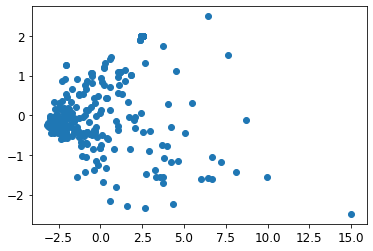

In [21]:
#quick visulization:
plt.scatter(transformed[:,0], transformed[:,1])

In [22]:
transformed_dataframe = pd.DataFrame(transformed, columns = ["0", "1"])
transformed_with_names = pd.concat([activation_elastic[['name', 'activated']], transformed_dataframe], axis=1)
transformed_with_names.head(3)

,name,activated,0,1
0,ACAJIZ_clean,yes,3.775515,-1.718064
1,ACAJOF_clean,yes,-0.882956,-1.045290
2,ACUFEK_clean,yes,-2.085671,0.901114


In [23]:
transformed_activated = transformed_with_names[transformed_with_names['activated']=='yes']
transformed_collapsed = transformed_with_names[transformed_with_names['activated']=='no']

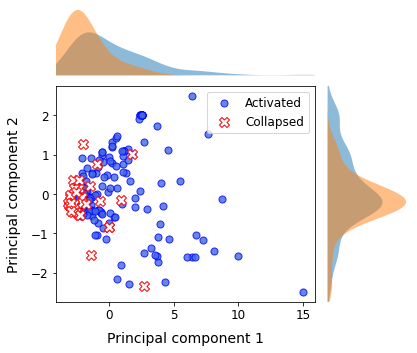

In [24]:
from matplotlib.ticker import NullFormatter
from sklearn.neighbors import KernelDensity

#-----------------------------------------------
xa = transformed_activated['0']
xc = transformed_collapsed['0']

ya = transformed_activated['1']
yc = transformed_collapsed['1']

Xlabel = "Principal component 1"
Ylabel = "Principal component 2"
#------------------------------------------------

#https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html

# definitions for the axes
left, width = 0.15, 0.6
bottom, height = 0.15, 0.6
spacing = 0.02
 
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(6, 5))

ax_scatter = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

# no labels
nullfmt = NullFormatter()   
ax_histx.xaxis.set_major_formatter(nullfmt)
ax_histy.yaxis.set_major_formatter(nullfmt)

#------------------------------  the scatter plot -------------------------------#
ax_scatter.scatter(x=xa, y =ya, c = 'royalblue', edgecolor ='blue', alpha = 0.8,
            s =50,  label = "Activated")
ax_scatter.scatter(x=xc, y =yc, marker= "X", s =100,
            edgecolor ='r', c ='w', label = "Collapsed")
ax_scatter.legend(loc ='upper right')
ax_scatter.set_xlabel(Xlabel, fontsize = 14, labelpad= 10)
ax_scatter.set_ylabel(Ylabel, fontsize = 14, labelpad= 10)

#------------------------------ Upper histogram ---------------------------------#
xlim1, xlim2 = ax_scatter.get_xlim()
x_d = np.linspace(xlim1, xlim2 ,1000)
mi1 = min(min(xa), min(xc))
mx1 = max(max(xa), max(xc))
bw = (mx1-mi1)/15

# fitting activated
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xa[:, None])
log_density_1 = kde.score_samples(x_d[:, None])
# fitting collapsed
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(xc[:, None])
log_density_2 = kde.score_samples(x_d[:, None])
ax_histx.fill_between(x_d, np.exp(log_density_1), alpha=0.5, label='Activated')
ax_histx.fill_between(x_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')

#----------------------------- Right histogram --------------------------------#

ylim1, ylim2 = ax_scatter.get_ylim()
y_d = np.linspace(ylim1, ylim2 ,1000)
mi2 = min(min(ya), min(yc))
mx2 = max(max(ya), max(yc))
bw = (mx2-mi2)/15

# fitting the activated MOFs
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(ya[:, None])
log_density_1 = kde.score_samples(y_d[:, None])
# fitting the collapsed MOFs
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(yc[:, None])
log_density_2 = kde.score_samples(y_d[:, None])
#----
ax_histy.fill_betweenx(y_d, np.exp(log_density_1), alpha=0.5, label='Activated')
ax_histy.fill_betweenx(y_d, np.exp(log_density_2), alpha=0.5, label='Collapsed')

#--------- axises limits of the histograms should be same as for the scatter plots ---------#

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

#------------------ remove the axis and frame of the histograms ----------------------------#
ax_histx.set_yticks([])
ax_histy.set_xticks([])
ax_histx.axis('off')
ax_histy.axis('off')
#--------------------------------------------------------------------------------------------#

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)

plt.savefig("Principal_component_analysis", dpi=200)


# -----------------------------   Looking for anomalies ----------------------------------

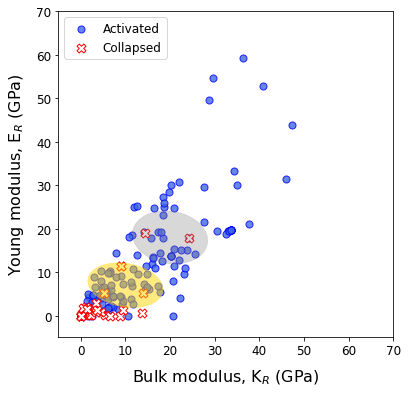

In [25]:

X1 = activated_elastic['Kr']
X2 = collapsed_elastic['Kr']

Y1 = activated_elastic['Er']
Y2 = collapsed_elastic['Er']

fig, ax = plt.subplots(figsize=(6,6))

#----------------------------------  Main plot -------------------------------------------------#
ax.scatter(x = X1, y = Y1, c = 'royalblue', edgecolor ='blue', s =50,  alpha = 0.8, label = "Activated", zorder = 1)
ax.scatter(x = X2, y = Y2, marker= "X",  s =80, c= 'w',  edgecolor ='r', label = "Collapsed", zorder = 2)
plt.legend(loc ='upper left')
plt.xlabel("Bulk modulus, K${_R}$ (GPa)", fontsize = 16, labelpad= 10)
plt.ylabel("Young modulus, E${_R}$ (GPa)", fontsize = 16, labelpad= 10)
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.xlim([-5,70])
plt.ylim([-5,70])

#-------------------------- draw ellipse with color -------------------------------------------#
from matplotlib import patches
e1 = patches.Ellipse((20, 18), width=12, height=17, angle=80, linewidth=0.5, 
                    fill=True, color = 'grey', alpha = 0.3, ec = 'grey',
                    zorder=3) # to make the plot on the front, if you want to put in the back set to 0 

e2 = patches.Ellipse((10, 7), width=17, height=10, angle=-10, linewidth=0.5, 
                    fill=True, color = 'gold', alpha = 0.5, ec = 'gold',
                    zorder=3) # to make the plot on the front, if you want to put in the back set to 0  
ax.add_patch(e1)
ax.add_patch(e2)


#------------------------------
#plt.box(on=None)
"""import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True """
#----------------------------------------------------------------------------------------

plt.savefig("bulk&young - no border.png", transparent= True, dpi=200)


In [26]:
collapsed_elastic[(collapsed_elastic['Er']>= 3)&(collapsed_elastic['Kr']>= 5)]

,name,Kv,Kr,Gv,Gr,Ev,Er,K,G,E,activated,N2_BET,N2_Langmiur,last solvent,method
38,DAKVUI_clean,26.690,24.351,8.031,6.517,21.896761,17.949720,25.5205,7.2740,19.923240,no,0.0,0.0,many,exchange
42,DOPHOH_clean,8.954,8.954,9.252,4.420,20.645225,11.386424,8.9540,6.8360,16.015825,no,0.0,0.0,freeze,freeze
43,DOPHUN_clean,8.955,8.955,9.252,4.420,20.645816,11.386604,8.9550,6.8360,16.016210,no,0.0,0.0,freeze,freeze
78,HABQUY_clean,14.355,14.348,7.740,7.410,19.682498,18.965159,14.3515,7.5750,19.323828,no,0.0,0.0,dichloromethane,exchange
139,MUNDEG_clean,5.757,5.102,3.173,1.917,8.041609,5.110887,5.4295,2.5450,6.576248,no,0.0,0.0,many,exchange
175,QIYDIN01_clean,16.098,14.032,3.451,1.814,9.662533,5.217181,15.0650,2.6325,7.439857,no,0.0,0.0,dichloromethane,exchange


# --------------------------------- Eigenvalues-----------------------------------------

In [27]:
eigen = pd.read_csv("Eigen_values_strain_1.0.csv")
eigen = pd. DataFrame(eigen)
eigen.head(3)

,name,gamma1,gamma2,gamma3,gamma4,gamma5,gamma6
0,ACAJIZ_clean,94.826186,20.821686,29.397283,7.827909,7.399167,33.416648
1,ACAJOF_clean,22.303708,0.905053,15.692335,11.933872,8.769366,13.776541
2,ACUFEK_clean,41.222949,2.992889,-0.254638,-0.487189,1.747438,1.383586


In [28]:
#add column for the smallest eignevalue
eigen['gamma_smallest'] = eigen.min(axis=1)

In [29]:
activation_eigen = pd.merge(eigen, activation_data, on = 'name', how = "inner" )
activation_eigen.head(3)

,name,gamma1,gamma2,gamma3,gamma4,gamma5,gamma6,gamma_smallest,activated,N2_BET,N2_Langmiur,last solvent,method
0,ACAJIZ_clean,94.826186,20.821686,29.397283,7.827909,7.399167,33.416648,7.399167,yes,0.0,0.0,chloroform,exchange
1,ACAJOF_clean,22.303708,0.905053,15.692335,11.933872,8.769366,13.776541,0.905053,yes,0.0,0.0,chloroform,exchange
2,ACUFEK_clean,41.222949,2.992889,-0.254638,-0.487189,1.747438,1.383586,-0.487189,yes,NaN,3800.0,dichloromethane,exchange


In [30]:
activated_eigen = activation_eigen[(activation_eigen['activated'] == 'yes')]
collapsed_eigen = activation_eigen[(activation_eigen['activated'] == 'no')]

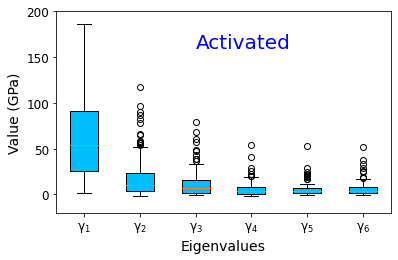

In [31]:
#Box plot --> ACTIVATED

data = activated_eigen[['gamma1', 'gamma2','gamma3', 'gamma4', 'gamma5', 'gamma6']]
labels = ['γ${_1}$', 'γ${_2}$', 'γ${_3}$', 'γ${_4}$', 'γ${_5}$', 'γ${_6}$']
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(bottom=0.15, top=0.85)

bplot1= ax.boxplot(data, patch_artist=True, labels = labels)
ax.set_xlabel('Eigenvalues', fontsize = 14, labelpad =5)
ax.set_ylabel('Value (GPa)', fontsize = 14, labelpad =5)
plt.ylim([-20,200])

#--------------------------------------------------------------------#
plt.text(3, 160, 'Activated', fontsize = 20, color = 'blue')
#--------------------------------------------------------------------#
# fill with colors
from colour import Color
main_color = Color("deepskyblue")
n = 6
colors = list(main_color.range_to(Color("deepskyblue"),n))
colors = [color.rgb for color in colors]

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
        
plt.savefig("boxplot_activated.png", dpi=200)

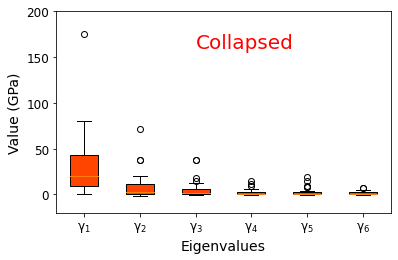

In [32]:
#Box plot --> COLLAPSED

data = collapsed_eigen[['gamma1', 'gamma2','gamma3', 'gamma4', 'gamma5', 'gamma6' ]]
labels = ['γ${_1}$', 'γ${_2}$', 'γ${_3}$', 'γ${_4}$', 'γ${_5}$', 'γ${_6}$']
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(bottom=0.15, top=0.85)

bplot1= ax.boxplot(data, patch_artist=True, labels = labels)
ax.set_xlabel('Eigenvalues', fontsize = 14, labelpad =5)
ax.set_ylabel('Value (GPa)', fontsize = 14, labelpad =5)
plt.ylim([-20,200])

#--------------------------------------------------------------------#
plt.text(3, 160, 'Collapsed', fontsize = 20, color = 'red')
#--------------------------------------------------------------------#
# fill with colors
from colour import Color
main_color = Color("orangered")
n = 6
colors = list(main_color.range_to(Color("orangered"),n))
colors = [color.rgb for color in colors]

for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
        
plt.savefig("boxplot_collapsed.png", dpi=200)

In [33]:
#Number of MOFs violating the Born's stability criterion (MOFs with egative eigenvalues)
violated_activated = activated_eigen[activated_eigen['gamma_smallest'] < 0]
violated_collapsed = collapsed_eigen[collapsed_eigen['gamma_smallest'] < 0]

print ("Activated MOFs that violated Born's criterion = ", len(violated_activated))
print ("Collapsed Activated MOFs that violated Born's criterion = ", len(violated_collapsed))

print ("Percentage of violated activated = ", 100* len(violated_activated)/len(activated_eigen))
print ("Percentage of violated collapsed = ", 100* len(violated_collapsed)/len(collapsed_eigen))

Activated MOFs that violated Born's criterion =  15
Collapsed Activated MOFs that violated Born's criterion =  7
Percentage of violated activated =  8.720930232558139
Percentage of violated collapsed =  23.333333333333332
